# Micrograd
So this guy is where we build a neural net from scratch.
We literally will make one, and perform back propagation by deriving some of the math


In [32]:
import numpy as np
import graphviz as gz
import matplotlib.pyplot as plt
import math

%matplotlib inline


## Constructing ADT
Here we setup the initial ADT for discrete integer boxing, which will allow us to build a graph of operations that will eventually be topologically sorted to perform back propogation.
* One thing that i want to learn to do is write math formulas inline in markdown.  Please papa Andrej do this in the future.

In [92]:
class Value:
    def __init__(self, data, _children=(), _op=None, label=''):
        self.data = data
        self.label = label
        self._grad = 0.0
        self._children = set(_children)
        self._op = _op
        self._back = lambda: None
    def __repr__(self) -> str:
        if self._op == None:
            return f"Value({self.label}: {self.data: .4f})"
        else:
            return f"Value({self.label}: {self.data: .4f} = ({self._op} {[c.data for c in self._children]}))"

    def __add__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data + o.data, (self, o), '+')
        def _back():
            self._grad += 1.0 * out._grad
            o._grad += 1.0 * out._grad
        out._back = _back
        return out

    def __sub__(self, o) -> 'Value':
        # o = o if isinstance(o, Value) else Value(o)
        # out = Value(self.data - o.data, (self, o), '-')
        # def _back():
        #     self._grad += 1.0 * out._grad
        #     o._grad += -1.0 * out._grad
        # out._back = _back
        out = self + (o * -1) ; out._op='-'
        return out

    def __mul__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data * o.data, (self, o), '*')
        def _back():
            self._grad += o.data * out._grad
            o._grad += self.data * out._grad
        out._back = _back
        return out
    
    # a / b => a * (1/b) => a * b^-1
    def __truediv__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = self * o ** (-1); out._op = '/'
        return out
    
    def __pow__(self, o) -> 'Value':
        o = o if isinstance(o, Value) else Value(o)
        out = Value(self.data ** o.data, (self, o), 'pow')
        def _back():
            self._grad += (o.data * self.data ** (o.data  - 1)) * out._grad
            o._grad += math.log(self.data) * out.data * out._grad
        out._back = _back
        return out
        
    
    def tanh(self) -> 'Value':
        t = (2 * self).exp()
        tanh = (t - 1) / (t + 1)
        return tanh

    def ptanh(self) -> 'Value':
        t = math.exp(2 * self.data)
        tanh = (t - 1) / (t + 1)
        out = Value(tanh, (self,), 'tanh')
        def _back():
            self._grad += (1 - tanh**2) * out._grad
        out._back = _back
        return out
    
    def exp(self) -> 'Value':
        out = Value(math.exp(self.data), (self,), 'exp')
        def back():
            self._grad += out.data * out._grad
        out._back = back
        return out

    def backward(self):
        self._grad = 1.
        q = [self]
        seen = set()
        while len(q) > 0:
            n = q.pop()
            if n not in seen:
                n._back()
                q.extend(n._children)
                seen.add(n)

    def zero_back(self):
        self._grad = 0;
        q = [self]
        seen = set()
        while len(q) > 0:
            n = q.pop()
            if n not in seen:
                n._grad = 0
                q.extend(n._children)
                seen.add(n)

    
    def __radd__(self, o) -> 'Value':
        return self + o
    def __rsub__(self, o) -> 'Value':
        return self - o
    def __rmul__(self, o) -> 'Value':
        return self * o
    def __rtruediv__(self, o) -> 'Value':
        return self / 0


In [93]:
a = Value(.4, label='a')
b = Value(.3 , label='b')
c = a + b; c.label = 'c'
d = a * .3; d.label = 'd'
e = c * d + a + .3; e.label = 'e'
f = e.tanh(); f.label = 'f'

print(e._children)

print((a*a)._children)


{Value(:  0.3000), Value(:  0.4840 = (+ [0.4, 0.08399999999999999]))}
{Value(a:  0.4000)}


## Graphing the graph
Lets plot this sucker using graphviz. Turns out the api is pretty easy to use. We can use recursion to build up our nodes in BFS order.

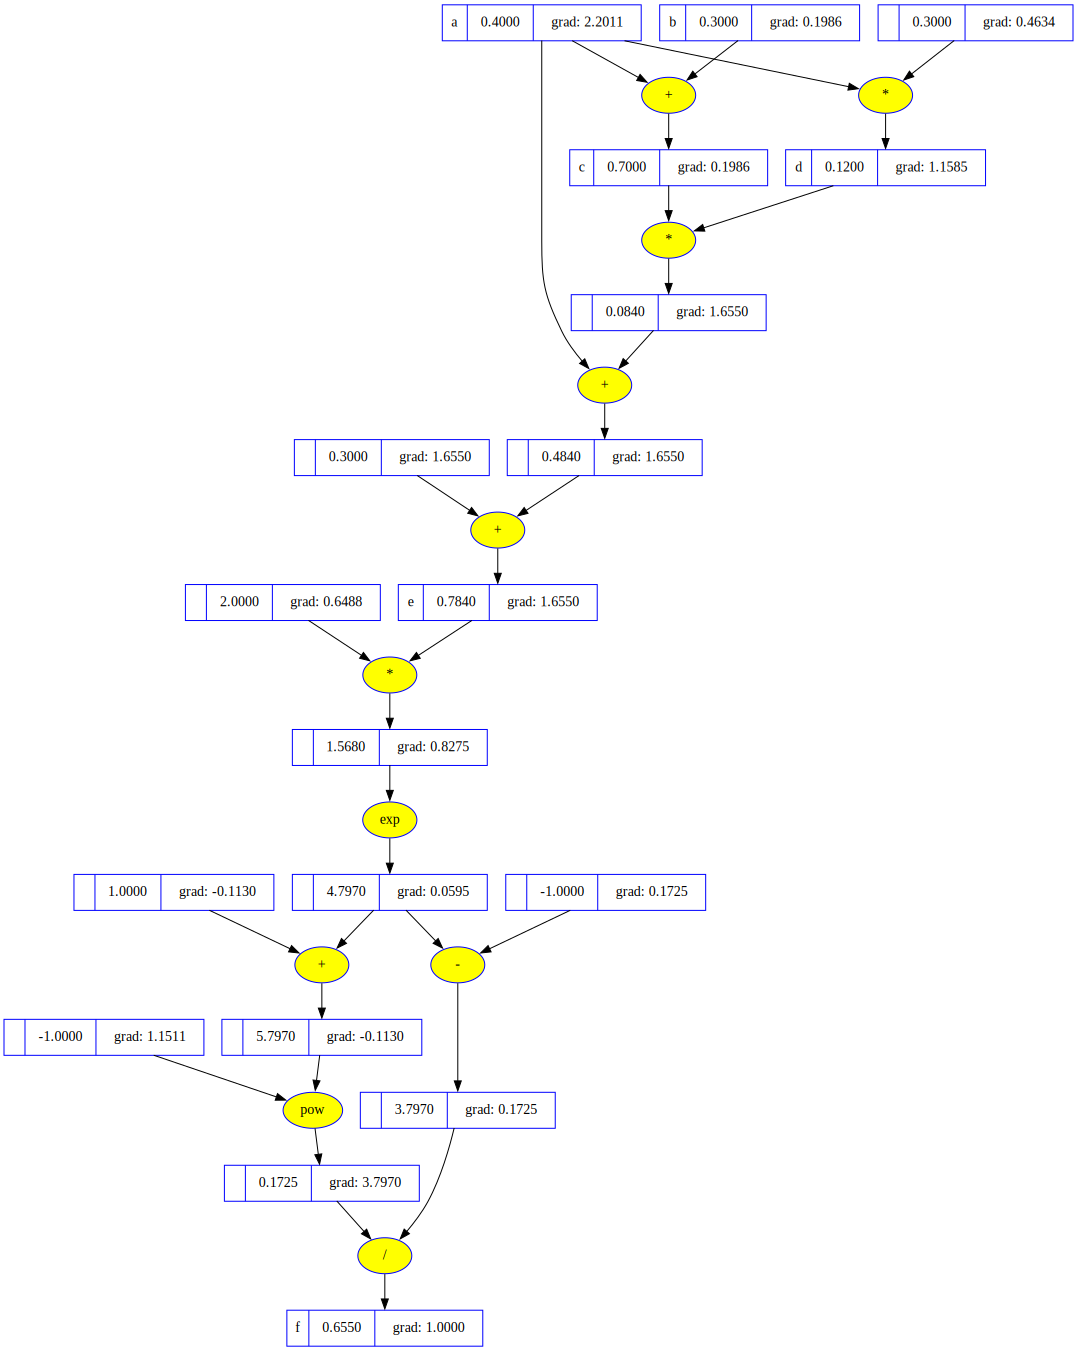

In [95]:
def graph_value(v: Value):
    visited = {}
    g = gz.Digraph('G', node_attr={'shape': 'record', 'color': 'blue'}, edge_attr={})
    def ns(n: int, v : Value) -> str:
        g.node(str(n), f'{v.label}|{v.data : .4f}|grad: {v._grad: .4f}')
        if v._op is not None:
            n += 1
            g.node(str(n), v._op, shape='ellipse', style='filled', fillcolor='yellow')
            g.edge(str(n), str(n-1))
        n0 = n
        for v in v._children:
            assert(isinstance(n, int))
            if v not in visited:
                n0 =  n0 + 1
                n2 = ns(n0, v)
                g.edge(str(n0), str(n))
                visited[v] = str(n0)
                n0 = n2
            else:
                g.edge(visited[v], str(n))
        return n0
    ns(1,v)
    return g

f.zero_back()
f.backward()
graph_value(f)


In [ ]:
def f(x):
    return 3 * x** 2 - 4 * x + 5
xs = np.arange(-5, 5, .25)
ys = f(xs)

plt.plot(xs, ys)


# Derivatives

Given the following definition of a derivative for $f(x)$ <br>
${{df}\over{dx}}=\lim\limits_{h \to 0}{{f(x + h) - f(x)}\over{h}}$

We can now define a derivative for the following operations

* $f(g, k) = g * k$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h) * k) - (g * k) \over h}$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{(g* k) - (g * k) + (h*k) \over h}$ <br>
$\implies {df\over dg} = k $ <br>
$\Box$

* $f(g,k) = g + k$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h) + k) - (g + k) \over h}$ <br>
$\implies {df\over dg} = \lim\limits_{h\to0}{(g - g) +  (k - k) + h\over h}$ <br>
$\implies {df\over dg} = 1 $ <br>
$\Box$


* $f(g,k) = g^k$ <br>

$\implies {df\over dg} = \lim\limits_{h\to0}{((g+h)^k) - (g^k) \over h}$ <br>